In [3]:
import pandas as pd

va_building_permits = pd.read_csv('./va_building_permits.csv')
va_housing_prices = pd.read_csv('./va_housing_prices.csv')
va_median_household_income = pd.read_csv('./va_median_household_income.csv')
va_population = pd.read_csv('./va_population.csv')
va_population['VAPOP'] = va_population['VAPOP'] * 1000
va_personal_income = pd.read_csv('./va_personal_income.csv')
va_unemployment_rate = pd.read_csv('./va_unemployment_rate.csv')
va_rental_vacancy_rate = pd.read_csv('./va_rental_vacancy_rate.csv')


In [4]:
# Convert DATE columns to datetime format
datasets = [va_building_permits, va_housing_prices, va_median_household_income,
            va_personal_income, va_population, va_unemployment_rate, va_rental_vacancy_rate]

for df in datasets:
    df['DATE'] = pd.to_datetime(df['DATE'])

# Resample yearly data to monthly by forward-filling
for df in [va_median_household_income, va_personal_income, va_population]:
    df.set_index('DATE', inplace=True)
    df = df.resample('M').ffill().reset_index()

# Begin merging with va_building_permits as the base
merged_df = va_building_permits

# Merge each dataset on the DATE column, including the new population dataset
for df in [va_housing_prices, va_median_household_income, va_personal_income,
           va_population, va_unemployment_rate, va_rental_vacancy_rate]:
    merged_df = pd.merge(merged_df, df, on='DATE', how='outer')

# Rename columns to descriptive names
merged_df.rename(columns={
    'DATE': 'Date',
    'VABPPRIV': 'Building Permits',
    'VAUCSFRCONDOSMSAMID': 'Housing Price Index',
    'MEHOINUSVAA646N': 'Median Household Income',
    'VAPCPI': 'Personal Income Per Capita',
    'VARVAC': 'Rental Vacancy Rate',
    'VAUR': 'Unemployment Rate',
    'VAPOP': 'Population'
}, inplace=True)

# Fill remaining NaNs by using the yearly average for each column
merged_df['Year'] = merged_df['Date'].dt.year
for column in merged_df.columns.drop(['Date', 'Year']):
    merged_df[column] = merged_df.groupby('Year')[column].transform(lambda x: x.fillna(x.mean()))

# Drop the Year column used for grouping
merged_df.drop(columns=['Year'], inplace=True)
merged_df.dropna(inplace=True)

# Save the cleaned monthly dataset to a new CSV file

# Display the first few rows of the final dataset to confirm
print(merged_df.head())

<ipython-input-4-c41d2b6dca18>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').ffill().reset_index()
<ipython-input-4-c41d2b6dca18>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').ffill().reset_index()
<ipython-input-4-c41d2b6dca18>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').ffill().reset_index()


          Date  Building Permits  Housing Price Index  \
364 2000-01-01            3507.0        123345.473614   
365 2000-02-01            3890.0        123664.646325   
366 2000-03-01            5046.0        124003.044321   
367 2000-04-01            3996.0        124642.503988   
368 2000-05-01            4138.0        125259.832254   

     Median Household Income  Personal Income Per Capita  Population  \
364                  47160.0                     32631.0   7105817.0   
365                  47160.0                     32631.0   7105817.0   
366                  47160.0                     32631.0   7105817.0   
367                  47160.0                     32631.0   7105817.0   
368                  47160.0                     32631.0   7105817.0   

     Unemployment Rate  Rental Vacancy Rate  
364                2.6                  7.7  
365                2.5                  7.7  
366                2.4                  7.7  
367                2.4                  

In [5]:
merged_df['Building Permits'] = merged_df['Building Permits'].round(0).astype(int)
merged_df['Housing Price Index'] = merged_df['Housing Price Index'].round(2)
merged_df['Building Permits'] = merged_df['Building Permits'].round(0)
merged_df['Median Household Income'] = merged_df['Median Household Income'].round(0).astype(int)
merged_df['Personal Income Per Capita'] = merged_df['Personal Income Per Capita'].round(0).astype(int)
merged_df['Population'] = merged_df['Population'].round(0).astype(int)
merged_df['Unemployment Rate'] = merged_df['Unemployment Rate'].round(1)
merged_df['Rental Vacancy Rate'] = merged_df['Rental Vacancy Rate'].round(1)

merged_df.to_csv('./va_housing_market_monthly_aggregated.csv', index=False)

In [6]:
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('./va_housing_market_monthly_aggregated.csv')
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

data.head()

,Date,Building Permits,Housing Price Index,Median Household Income,Personal Income Per Capita,Population,Unemployment Rate,Rental Vacancy Rate
0,2000-01-01,0.332271,-1.936566,-1.436291,-1.48808,-1.866732,-1.133833,-0.128201
1,2000-02-01,0.658442,-1.931174,-1.436291,-1.48808,-1.866732,-1.199076,-0.128201
2,2000-03-01,1.642915,-1.925458,-1.436291,-1.48808,-1.866732,-1.264320,-0.128201
3,2000-04-01,0.748713,-1.914655,-1.436291,-1.48808,-1.866732,-1.264320,-0.128201
4,2000-05-01,0.869644,-1.904227,-1.436291,-1.48808,-1.866732,-1.329564,-0.128201


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf


# Set the target variable (e.g., 'Housing Price Index') and features
target = 'Housing Price Index'
features = data.columns.drop(['Date', target])

X = data[features]
y = data[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
print("Linear Regression")
print("MSE:", mean_squared_error(y_test, y_pred_lin))
print("R^2 Score:", r2_score(y_test, y_pred_lin))

Linear Regression
MSE: 0.1037153850308602
R^2 Score: 0.8860678860271212


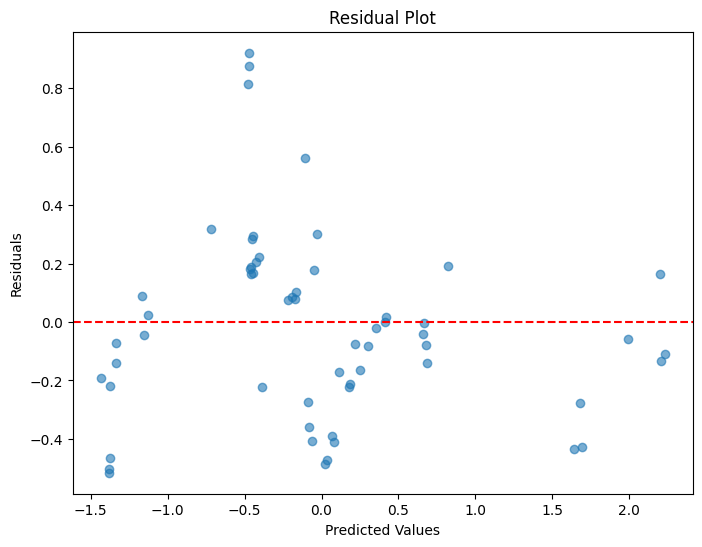

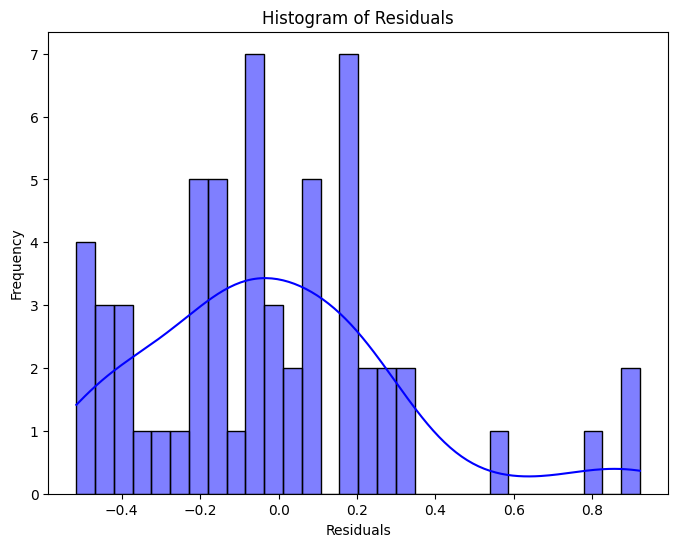

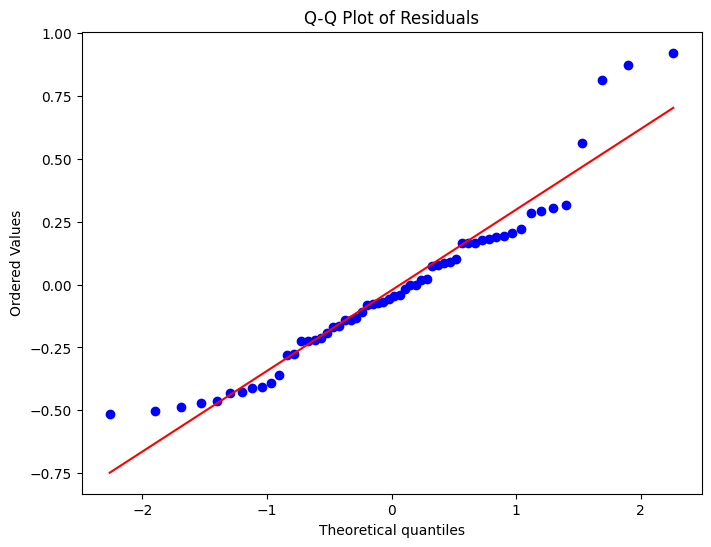

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

residuals = y_test - y_pred_lin

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lin, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [12]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
lasso_cv_scores = cross_val_score(lasso, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

print("Ridge Regression Cross-Validation R^2 Scores:", ridge_cv_scores)
print("Ridge Regression Mean R^2 Score:", np.mean(ridge_cv_scores))

print("nLasso Regression Cross-Validation R^2 Scores:", lasso_cv_scores)
print("Lasso Regression Mean R^2 Score:", np.mean(lasso_cv_scores))

Ridge Regression Cross-Validation R^2 Scores: [-0.12880636 -0.07943507 -0.15299794 -0.14992432 -0.13771773]
Ridge Regression Mean R^2 Score: -0.12977628621846843
nLasso Regression Cross-Validation R^2 Scores: [-1.06291654 -0.9152918  -0.91209267 -1.2882718  -0.95311405]
Lasso Regression Mean R^2 Score: -1.0263373715913362


In [ ]:
# 2. Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
print("\nRandom Forest Regressor")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R^2 Score:", r2_score(y_test, y_pred_rf))
print('hello')